In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from evoman.environment import Environment
from controller1 import player_controller
from evoman.controller import Controller
from multiprocessing import Pool
from scipy.stats import ttest_ind, mannwhitneyu
import pandas as pd
import warnings

pygame 2.6.0 (SDL 2.28.4, Python 3.9.13)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

In [3]:
best_solutions_a = pd.read_csv('best_solutions_a.csv')
best_solutions_b = pd.read_csv('best_solutions_b.csv')

In [4]:
results_b = pd.read_csv('results_b.csv')

In [5]:
results_b

,Algorithm,Enemy,Run,Generation,Mean Fitness,Max Fitness,Best Solution
0,B,1,1,1,10.795714,94.306268,[ 9.63098599e-02 -1.51275933e-01 1.39309832e-...
1,B,1,1,2,28.610202,94.319827,[ 9.63098599e-02 -1.51275933e-01 1.39309832e-...
2,B,1,1,3,55.989346,94.323246,[ 9.63098599e-02 -1.51275933e-01 1.39309832e-...
3,B,1,1,4,65.276796,94.323246,[ 9.63098599e-02 -1.51275933e-01 1.39309832e-...
4,B,1,1,5,66.139098,94.323246,[ 9.63098599e-02 -1.51275933e-01 1.39309832e-...
...,...,...,...,...,...,...,...
895,B,3,10,26,69.846283,94.182889,[ 0.10884969 -0.87897573 0.66503812 -0.823578...
896,B,3,10,27,71.465086,94.648142,[ 0.10884969 -0.87897573 0.66503812 -0.823578...
897,B,3,10,28,69.188060,94.648142,[ 0.10884969 -0.87897573 0.66503812 -0.823578...
898,B,3,10,29,70.570697,94.648142,[ 0.10884969 -0.87897573 0.66503812 -0.823578...


In [6]:
# Group by Algorithm, Enemy, Generation and compute mean and std
grouped = results_b.groupby(['Algorithm', 'Enemy', 'Generation']).agg(
    mean_fitness_mean=('Mean Fitness', 'mean'),
    mean_fitness_std=('Mean Fitness', 'std'),
    max_fitness_mean=('Max Fitness', 'mean'),
    max_fitness_std=('Max Fitness', 'std'),
).reset_index()

In [7]:
grouped

,Algorithm,Enemy,Generation,mean_fitness_mean,mean_fitness_std,max_fitness_mean,max_fitness_std
0,B,1,1,15.299971,5.191247,94.134398,0.568531
1,B,1,2,36.821586,11.836119,94.318473,0.004600
2,B,1,3,60.122940,8.203918,94.322975,0.012627
3,B,1,4,67.369410,5.902745,94.323997,0.012135
4,B,1,5,69.811033,5.361917,94.324680,0.011850
...,...,...,...,...,...,...,...
85,B,3,26,71.513193,2.222305,94.168637,0.451513
86,B,3,27,69.455603,3.233593,94.215162,0.476428
87,B,3,28,69.863474,2.764329,94.215162,0.476428
88,B,3,29,71.053668,2.514155,94.215162,0.476428


In [ ]:
plt.figure(figsize=(14, 6))
enemies = [1,2,3]
for enemy in enemies:
	# Subset data for the current enemy
	data_enemy = grouped[grouped['Enemy'] == enemy]

	# Plot Mean Fitness
	plt.subplot(1, 2, 1)
	sns.lineplot(data=data_enemy, x='Generation', y='mean_fitness_mean', hue='Algorithm', marker='o')
	plt.fill_between(
		data_enemy['Generation'],
		data_enemy['mean_fitness_mean'] - data_enemy['mean_fitness_std'],
		data_enemy['mean_fitness_mean'] + data_enemy['mean_fitness_std'],
		alpha=0.2
	)
	plt.title(f'Enemy {enemy}: Average Mean Fitness Across Generations')
	plt.xlabel('Generation')
	plt.ylabel('Mean Fitness')
	plt.legend(title='Algorithm')

	# Plot Max Fitness
	plt.subplot(1, 2, 2)
	sns.lineplot(data=data_enemy, x='Generation', y='max_fitness_mean', hue='Algorithm', marker='o')
	plt.fill_between(
		data_enemy['Generation'],
		data_enemy['max_fitness_mean'] - data_enemy['max_fitness_std'],
		data_enemy['max_fitness_mean'] + data_enemy['max_fitness_std'],
		alpha=0.2
	)
	plt.title(f'Enemy {enemy}: Average Max Fitness Across Generations')
	plt.xlabel('Generation')
	plt.ylabel('Max Fitness')
	plt.legend(title='Algorithm')

	plt.tight_layout()
	plt.show()


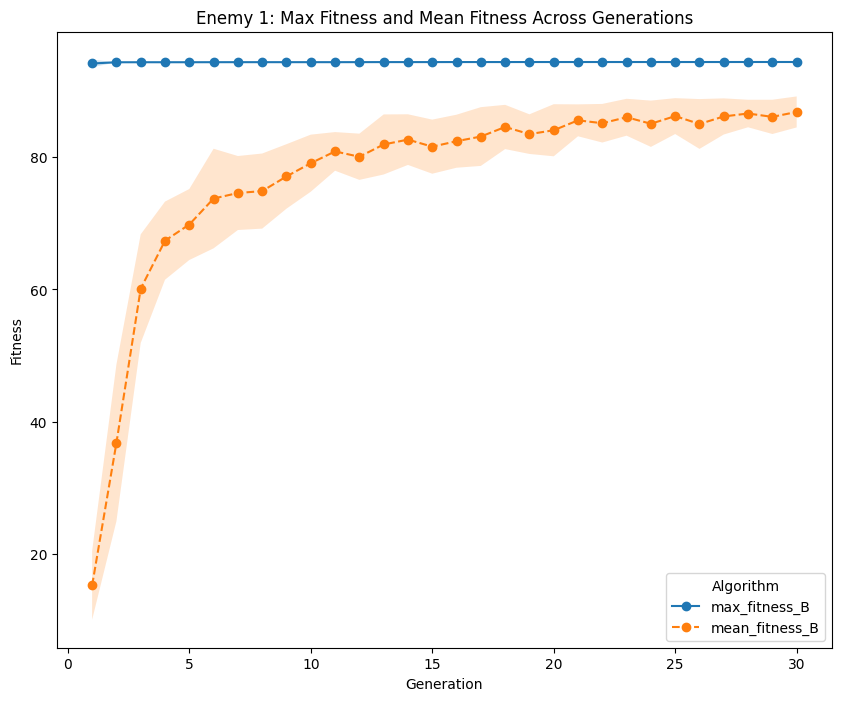

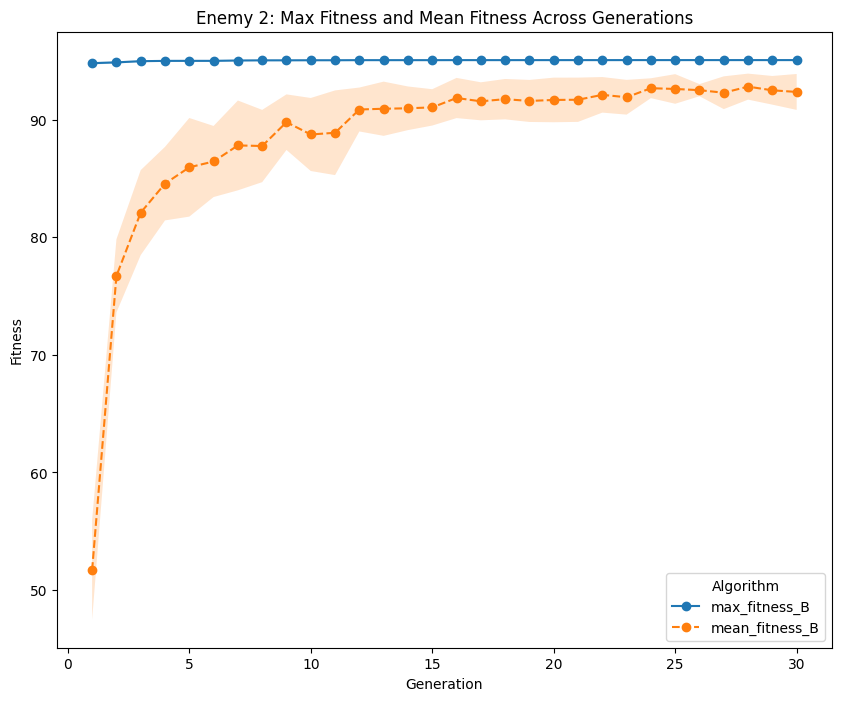

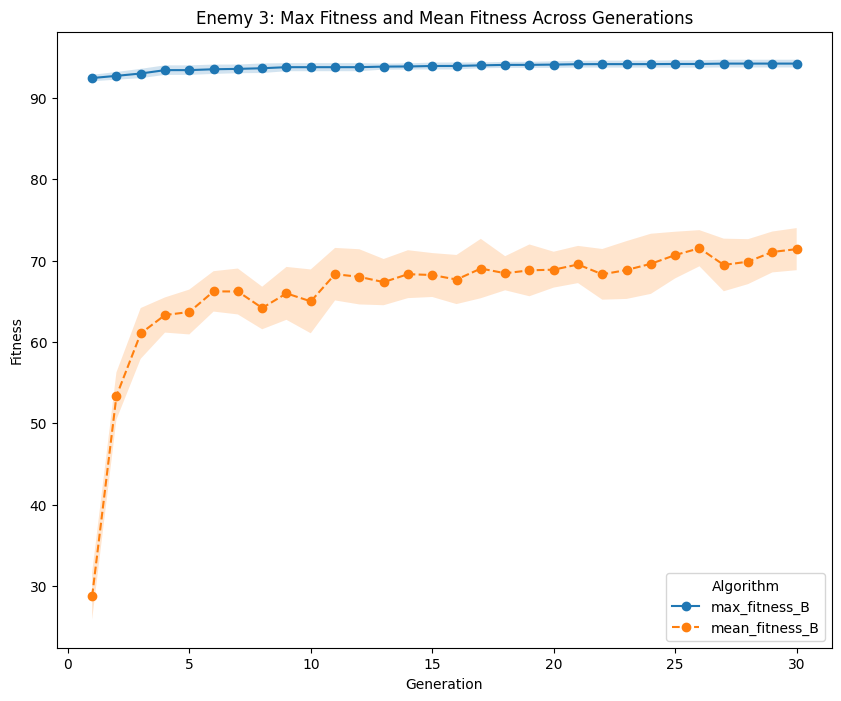

In [8]:

enemies = [1,2,3]
for enemy in enemies:
    plt.figure(figsize=(10, 8))
    data_enemy = grouped[grouped['Enemy'] == enemy]

    algorithms = data_enemy['Algorithm'].unique()

    for algorithm in algorithms:
        data_alg = data_enemy[data_enemy['Algorithm'] == algorithm]
        
        # Max Fitness
        plt.plot(
            data_alg['Generation'], 
            data_alg['max_fitness_mean'], 
            label=f'max_fitness_{algorithm}', 
            marker='o'
        )
        # Max Fitness Std
        plt.fill_between(
            data_alg['Generation'],
            data_alg['max_fitness_mean'] - data_alg['max_fitness_std'],
            data_alg['max_fitness_mean'] + data_alg['max_fitness_std'],
            alpha=0.2
        )
        
        # Mean Fitness
        plt.plot(
            data_alg['Generation'], 
            data_alg['mean_fitness_mean'], 
            label=f'mean_fitness_{algorithm}', 
            marker='o', 
            linestyle='--'
        )
        # Mean Fitness Std
        plt.fill_between(
            data_alg['Generation'],
            data_alg['mean_fitness_mean'] - data_alg['mean_fitness_std'],
            data_alg['mean_fitness_mean'] + data_alg['mean_fitness_std'],
            alpha=0.2
        )

    plt.title(f'Enemy {enemy}: Max Fitness and Mean Fitness Across Generations')
    plt.xlabel('Generation')
    plt.ylabel('Fitness')

    plt.legend(title='Algorithm')

    plt.show()

In [9]:
# Group by 'Enemy' and find the row with the maximum 'Max Fitness' for each enemy
max_fitness_rows = results_b.loc[results_b.groupby('Enemy')['Max Fitness'].idxmax()]

# Display the results
print(max_fitness_rows)

    Algorithm  Enemy  Run  Generation  Mean Fitness  Max Fitness  \
222         B      1    8          13     79.496934    94.386872   
427         B      2    5           8     88.115069    95.072746   
654         B      3    2          25     70.618609    94.774253   

                                         Best Solution  
222  [-1.62652593e-01 -6.86512327e-01  8.60849729e-...  
427  [ 1.38473457e-01  1.00000000e+00 -6.72134145e-...  
654  [-0.47376041  0.68642016 -0.61457277  0.559381...  


In [17]:
enemies = [3]

experiment_name = 'test_other_enemies'
os.makedirs(experiment_name, exist_ok=True)

# Load best solutions
best_solutions_a = np.loadtxt('best_solution_b.txt')

n_hidden1 = 10
n_hidden2 = 5

for enemy in enemies:
	env = Environment(
		experiment_name=experiment_name,
		enemies=[enemy],
		playermode="ai",
		player_controller=player_controller(n_hidden1, n_hidden2),
		enemymode="ai",
		level=2,
		speed="fastest",
		visuals=True
	)

	f, _, _, _ = env.play(pcont=best_solutions_a)

	print(f'Enemy {enemy}: Fitness = {f:.4f}')


MESSAGE: Pygame initialized for simulation.
Enemy 3: Fitness = 94.5277


In [18]:
best_solutions_b

,Algorithm,Enemy,Run,Best Solution
0,B,1,1,[ 9.63098599e-02 -1.51275933e-01 1.39309832e-...
1,B,1,2,[ 0.95790577 -0.5083281 0.10536807 0.672391...
2,B,1,3,[ 2.44070372e-01 2.61802811e-01 -7.72142717e-...
3,B,1,4,[ 0.42025147 0.5413878 -0.91514348 -0.637616...
4,B,1,5,[ 5.50075064e-01 -6.91220735e-01 9.26548701e-...
5,B,1,6,[-9.42199283e-01 -5.28249349e-01 1.62451140e-...
6,B,1,7,[-0.06445043 0.27893707 -0.60477876 0.877579...
7,B,1,8,[-1.62652593e-01 -6.86512327e-01 8.60849729e-...
8,B,1,9,[ 0.80022168 -0.28565971 0.00878005 0.470897...
9,B,1,10,[ 0.34711929 0.98682629 -0.40644252 -0.748992...
